# 準備資料

In [2]:
import pandas as pd
from function_tool import *

In [3]:
tej_data = pd.read_pickle('/Users/yangzherui/Desktop/因子復刻/tej_twse.pkl')
tej_data['symbol'] = tej_data['symbol'].astype(str)
tej_data=tej_data.sort_values(by=['symbol', 'datetime'],ignore_index=True)
tej_data['adj_close']= tej_data['close_d'] * tej_data['adjfac']
#計算Fret
tej_data['fret01']=(tej_data.groupby('symbol')['adj_close'].shift(-1)/ tej_data['adj_close']) - 1
fret=['fret01']
for i in range(2,61):
    #print('fret'+str(i).zfill(2))
    fret.append('fret'+str(i).zfill(2))
    tej_data['fret'+str(i).zfill(2)] = (1+tej_data['fret'+str(i-1).zfill(2)])*(1+tej_data.groupby('symbol')['fret01'].shift(-i))-1
market_data = pd.read_pickle('/Users/yangzherui/Desktop/因子復刻/台灣加權指數資料.pkl')[['datetime','roi']]

In [4]:
tej_data['roi_shift1m']=ts_delay(tej_data,days=20,value_col='roi')
tej_data['SMB']=tej_data['mktcap']
tej_data['HML']=tej_data['pbr_tej']
tej_data=tej_data[['datetime','symbol','SMB','HML','roi','fret20']]

In [5]:
def calc_ivol(tej_data, market_data, window=21):
    #tej_data['roi_shift1m']=ts_delay(tej_data,days=20,value_col='roi')
    #tej_data['SMB']=tej_data['mktcap']
    #tej_data['HML']=tej_data['pbr_tej']
    tej_data=tej_data[['datetime','symbol','SMB','HML','roi']]
    import pandas as pd
    import statsmodels.api as sm
    from tqdm import tqdm
    df = pd.merge(tej_data, market_data.rename(columns={'roi':'MKT'}),
                  on='datetime', how='left')
    results = []
    for symbol, g in tqdm(df.groupby('symbol'), desc="計算 IVOL"):
        g = g.sort_values('datetime').copy()
        ivol_list = []
        for i in range(window, len(g)):
            sub = g.iloc[i-window:i]   
            y = sub['roi'].values
            X = sub[['MKT','SMB','HML']].values
            X = sm.add_constant(X)    # 加入截距項
            try:
                model = sm.OLS(y, X).fit()
                resid = model.resid
                ivol = resid.std()     # 殘差標準差 = IVOL
            except:
                ivol = None
            ivol_list.append((g.iloc[i]['datetime'], symbol, ivol))
        results.extend(ivol_list)
    ivol_df = pd.DataFrame(results, columns=['datetime','symbol','ivol'])
    return ivol_df

In [6]:
ivol_df = calc_ivol(tej_data, market_data, window=21)
print(ivol_df.head())

計算 IVOL: 100%|██████████| 1217/1217 [18:41<00:00,  1.09it/s]


    datetime symbol      ivol
0 2005-02-01   1101  1.472588
1 2005-02-02   1101  1.478884
2 2005-02-03   1101  1.436408
3 2005-02-14   1101  1.443608
4 2005-02-15   1101  1.513483


In [55]:
result=pd.merge(ivol_df,tej_data[['datetime','symbol','fret20','HML','roi']],on=['datetime','symbol'],how='left')
'''
# 市值排名
def cs_rank(df, value_col='value', ascending=False):
    return (
        df.groupby('datetime')[value_col]
          .transform(lambda x: x.rank(pct=False, ascending=ascending))
    )

result['SMB'] = cs_rank(result, value_col='SMB', ascending=False)
result = result[result['SMB'] <= 150]
del result['SMB']
'''
result = result.set_index(['datetime','symbol'])

In [56]:
pred_unstack=result['ivol'].unstack()
y_unstack=result['fret20'].unstack()

樣本外IC_MEAN：-0.070956
樣本外IC_IR：-0.460748
樣本外SPREAD：-0.001680


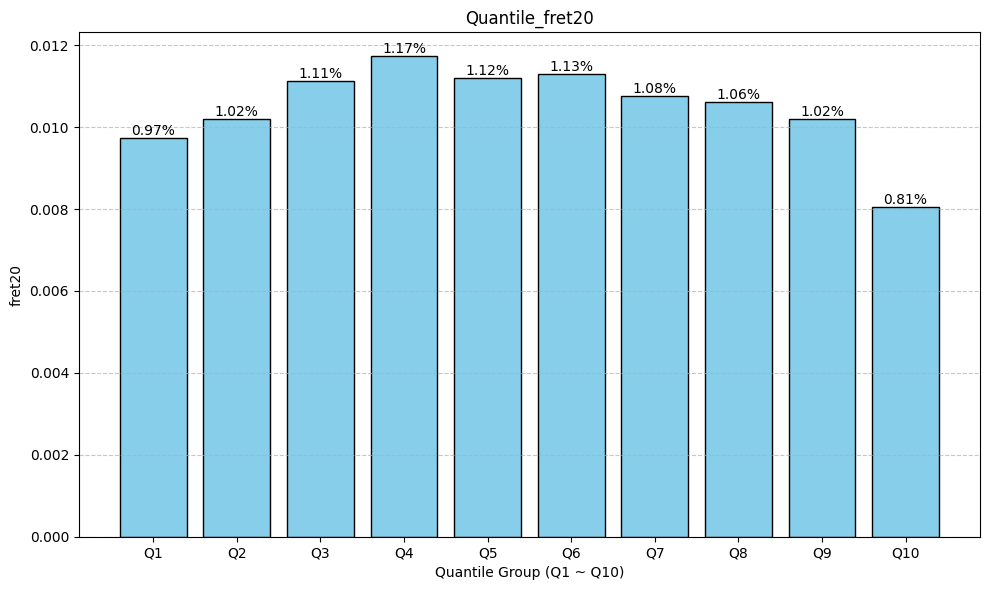

In [57]:
import matplotlib.pyplot as plt
ic_se = (y_unstack.rank(axis=1,pct=True)).corrwith(pred_unstack, axis=1, method='spearman')
ic_mean = ic_se.mean()
ic_ir = ic_mean / ic_se.std()
print(f'樣本外IC_MEAN：{ic_mean:.6f}')
print(f'樣本外IC_IR：{ic_ir:.6f}')

# 量化組績效
quantile_df = pd.DataFrame(index=pred_unstack.index, columns=[f'Q{i+1}' for i in range(10)] + ['spread'])
for dt in pred_unstack.index:
    pred = pred_unstack.loc[dt]
    actual = y_unstack.loc[dt]
    if pred.isna().all() or actual.isna().all():
        continue
    try:
        quantiles = pd.qcut(pred, 10, labels=False, duplicates='drop')
    except ValueError:
        continue
    for q in range(10):
        mask = quantiles == q
        if mask.sum() > 0:
            quantile_df.loc[dt, f'Q{q+1}'] = actual[mask].mean()
    q1 = quantile_df.loc[dt, 'Q1']
    q10 = quantile_df.loc[dt, 'Q10']
    if pd.notna(q1) and pd.notna(q10):
        quantile_df.loc[dt, 'spread'] = q10 - q1

spread = quantile_df['spread'].mean()
print(f'樣本外SPREAD：{spread:.6f}')

# 繪圖
mean_returns_by_quantile = quantile_df[[f'Q{i+1}' for i in range(10)]].astype(float).mean()
plt.figure(figsize=(10, 6))
bars = plt.bar(mean_returns_by_quantile.index, mean_returns_by_quantile.values, color='skyblue', edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2%}', ha='center', va='bottom', fontsize=10)
plt.title('Quantile_fret20')
plt.xlabel('Quantile Group (Q1 ~ Q10)')
plt.ylabel('fret20')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [58]:
print(result)

                       ivol    fret20     HML     roi
datetime   symbol                                    
2005-02-01 1101    1.472588  0.029707  1.0400  0.0000
2005-02-02 1101    1.478884  0.004925  1.0600  1.9900
2005-02-03 1101    1.436408 -0.026897  1.0800  1.4634
2005-02-14 1101    1.443608 -0.036203  1.0800  0.4808
2005-02-15 1101    1.513483 -0.048882  1.0700 -1.4354
...                     ...       ...     ...     ...
2025-07-15 9958    2.654773       NaN  4.3292 -2.1687
2025-07-16 9958    2.651008       NaN  4.2652 -1.4778
2025-07-17 9958    2.645845       NaN  4.2972  0.7500
2025-07-18 9958    2.684986       NaN  4.2652 -0.7444
2025-07-21 9958    2.681046       NaN  4.1906 -1.7500

[4271944 rows x 4 columns]


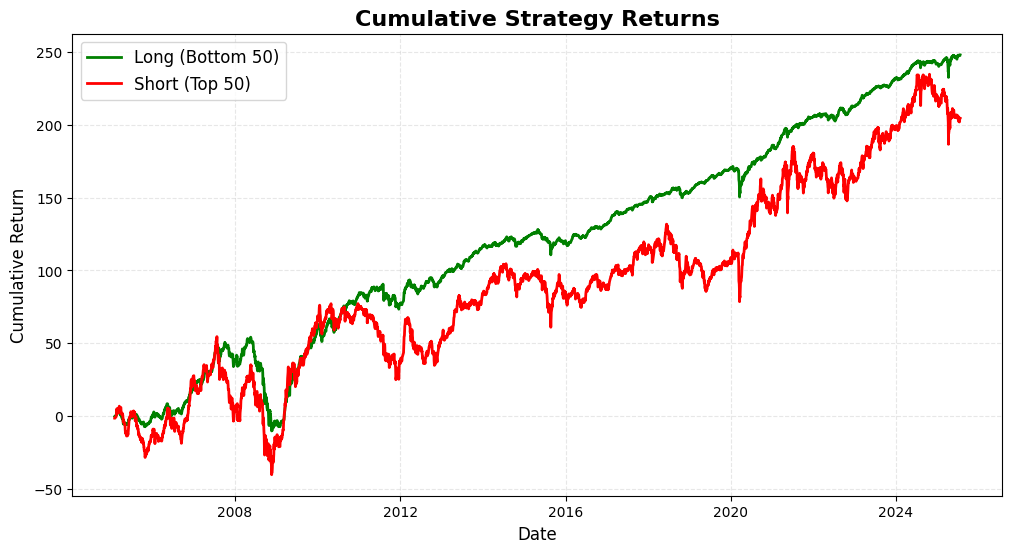

In [59]:
import matplotlib.pyplot as plt

# 多空報酬計算
return_day = result['roi'].unstack()

# Short Portfolio (Top 50)
short_position = (pred_unstack.rank(axis=1, pct=False, ascending=False) < 50).astype(float)
short_weighting = short_position.div(short_position.sum(axis=1), axis=0)
return_se_short = (short_weighting * return_day).sum(axis=1)

# Long Portfolio (Bottom 50)
long_position = (pred_unstack.rank(axis=1, pct=False, ascending=True) < 50).astype(float)
long_weighting = long_position.div(long_position.sum(axis=1), axis=0)
return_se_long = (long_weighting * return_day).sum(axis=1)

# 累積報酬
cum_short = return_se_short.cumsum()
cum_long = return_se_long.cumsum()

# 畫圖美化
plt.figure(figsize=(12,6))
plt.plot(cum_long, label="Long (Bottom 50)", color="green", linewidth=2)
plt.plot(cum_short, label="Short (Top 50)", color="red", linewidth=2)

plt.title("Cumulative Strategy Returns", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(fontsize=12, loc="best")
plt.grid(alpha=0.3, linestyle="--")

plt.show()

# 套利不對稱性與特質波動度

In [60]:
print(result)

                       ivol    fret20     HML     roi
datetime   symbol                                    
2005-02-01 1101    1.472588  0.029707  1.0400  0.0000
2005-02-02 1101    1.478884  0.004925  1.0600  1.9900
2005-02-03 1101    1.436408 -0.026897  1.0800  1.4634
2005-02-14 1101    1.443608 -0.036203  1.0800  0.4808
2005-02-15 1101    1.513483 -0.048882  1.0700 -1.4354
...                     ...       ...     ...     ...
2025-07-15 9958    2.654773       NaN  4.3292 -2.1687
2025-07-16 9958    2.651008       NaN  4.2652 -1.4778
2025-07-17 9958    2.645845       NaN  4.2972  0.7500
2025-07-18 9958    2.684986       NaN  4.2652 -0.7444
2025-07-21 9958    2.681046       NaN  4.1906 -1.7500

[4271944 rows x 4 columns]


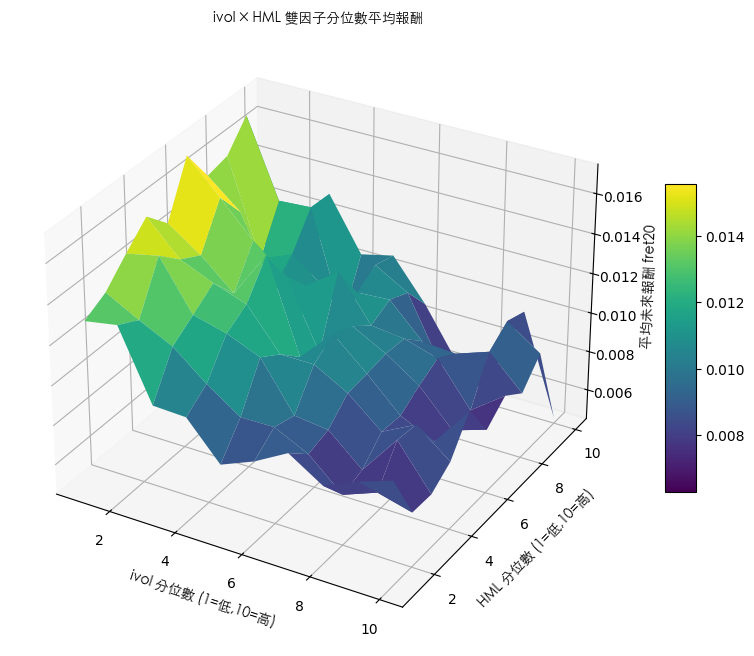

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.font_manager import FontProperties

# 字體
fm = "/Users/yangzherui/Desktop/台灣150指數增強/STHeiti Light.ttc"
font = FontProperties(fname=fm)

records = []
for date, group in result.groupby(level="datetime"):
    if len(group) < 100:
        continue
    g = group.copy()
    g["ivol_decile"] = pd.qcut(g["ivol"],10, labels=False) + 1
    g["HML_decile"]  = pd.qcut(g["HML"],10, labels=False) + 1
    
    avg_ret = g.groupby(["ivol_decile","HML_decile"])["fret20"].mean()
    for (i,h), v in avg_ret.items():
        records.append([date, i, h, v])

df2 = pd.DataFrame(records, columns=["datetime","ivol_decile","HML_decile","mean_ret"])
heat = df2.groupby(["ivol_decile","HML_decile"])["mean_ret"].mean().unstack()

# --- 畫 3D 圖 ---
X, Y = np.meshgrid(range(1,11), range(1,11))
Z = heat.fillna(0).values  # 補 NaN

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(X, Y, Z, cmap="viridis")

ax.set_xlabel("ivol 分位數 (1=低,10=高)", fontproperties=font)
ax.set_ylabel("HML 分位數 (1=低,10=高)", fontproperties=font)
ax.set_zlabel("平均未來報酬 fret20", fontproperties=font)
ax.set_title("ivol × HML 雙因子分位數平均報酬", fontproperties=font)

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


In [62]:
import pandas as pd
import numpy as np

records = []

# 假設 result 是你的 MultiIndex DataFrame，index 包含 "datetime"
for date, group in result.groupby(level="datetime"):
    if len(group) < 50:  # 5 分位數至少要有足夠樣本
        continue
    g = group.copy()
    
    # 5 分位數
    g["ivol_quantile"] = pd.qcut(g["ivol"], 5, labels=False) + 1
    g["HML_quantile"]  = pd.qcut(g["HML"], 5, labels=False) + 1
    
    # 計算平均報酬
    avg_ret = g.groupby(["ivol_quantile","HML_quantile"])["fret20"].mean()
    
    for (i,h), v in avg_ret.items():
        records.append([date, i, h, v])

# 建立 DataFrame
df5 = pd.DataFrame(records, columns=["datetime","ivol_quantile","HML_quantile","mean_ret"])

# 生成交叉平均報酬表格 (ivol × HML)
heat5 = df5.groupby(["ivol_quantile","HML_quantile"])["mean_ret"].mean().unstack()

# 顯示表格
print(heat5)

HML_quantile          1         2         3         4         5
ivol_quantile                                                  
1              0.013103  0.010547  0.008844  0.008442  0.008338
2              0.014966  0.012695  0.010565  0.008537  0.008668
3              0.015159  0.013149  0.010144  0.009220  0.008177
4              0.014405  0.010923  0.010797  0.009582  0.008640
5              0.011870  0.010736  0.010070  0.006210  0.007700


In [63]:
heat5 

HML_quantile,1,2,3,4,5
ivol_quantile,,,,,
1,0.013103,0.010547,0.008844,0.008442,0.008338
2,0.014966,0.012695,0.010565,0.008537,0.008668
3,0.015159,0.013149,0.010144,0.009220,0.008177
4,0.014405,0.010923,0.010797,0.009582,0.008640
5,0.011870,0.010736,0.010070,0.006210,0.007700
